# Your Title Here

**Name(s)**: (your name(s) here)

**Website Link**: (your website link)

In [265]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import plotly.express as px
pd.options.plotting.backend = 'plotly'

# from dsc80_utils import * # Feel free to uncomment and use this.

## Step 1: Introduction

In [266]:
csv_file_path = '/Users/samuelmahjouri/Desktop/dsc80/dsc80-2024-sp/projects/04-The Data Science Lifecycle/outage.csv'

# Load the CSV file
df_csv = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
df_csv.head()

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND


In [267]:
def cleaning(df):
    cleaned_df = df.copy(deep=True)
    cleaned_df.columns = df.iloc[4]
    cleaned_df = cleaned_df.drop(index=range(6))
    cleaned_df = cleaned_df.drop(columns=[cleaned_df.columns[0]]) 
    cleaned_df = cleaned_df.reset_index(drop=True)
    return cleaned_df

def more_cleaning(df):
    cleaned_df = cleaning(df)
    cleaned_df['OUTAGE.START.DATE'] = pd.to_datetime(cleaned_df['OUTAGE.START.DATE'])
    cleaned_df['OUTAGE.START'] = pd.to_datetime(cleaned_df['OUTAGE.START.DATE'].dt.strftime('%Y-%m-%d') + ' ' + cleaned_df['OUTAGE.START.TIME'])
    cleaned_df['OUTAGE.RESTORATION.DATE'] = pd.to_datetime(cleaned_df['OUTAGE.RESTORATION.DATE'])
    cleaned_df['OUTAGE.RESTORATION'] = pd.to_datetime(cleaned_df['OUTAGE.RESTORATION.DATE'].dt.strftime('%Y-%m-%d') + ' ' + cleaned_df['OUTAGE.RESTORATION.TIME'])
    cleaned_df = cleaned_df.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME','OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME' ])
    cleaned_df = cleaned_df.replace({pd.NaT: np.nan})
    return cleaned_df


cleaned_outages=more_cleaning(df_csv)
cleaned_outages[['ANOMALY.LEVEL', 'CAUSE.CATEGORY']]

4,ANOMALY.LEVEL,CAUSE.CATEGORY
0,-0.3,severe weather
1,-0.1,intentional attack
2,-1.5,severe weather
3,-0.1,severe weather
4,1.2,severe weather
...,...,...
1529,-0.9,public appeal
1530,NaN,fuel supply emergency
1531,0.5,islanding
1532,0.5,islanding


In [268]:
anomaly_level_order = cleaned_outages['ANOMALY.LEVEL'].unique()


bin_edges = range(int(cleaned_outages['ANOMALY.LEVEL'].astype(float).min()) - 1, 
                  int(cleaned_outages['ANOMALY.LEVEL'].astype(float).max()) + 2)

cleaned_outages['ANOMALY_BIN'] = pd.cut(cleaned_outages['ANOMALY.LEVEL'].astype(float), bins=bin_edges,right=False)

grouped = cleaned_outages.groupby(['CAUSE.CATEGORY', 'ANOMALY_BIN']).size().reset_index(name='count')

# Calculate the total count for each cause category
total_counts = grouped.groupby('CAUSE.CATEGORY')['count'].transform('sum')

# Calculate the percentage for each combination
grouped['percentage'] = grouped['count'] / total_counts * 100

# Extract bin labels for display
grouped['ANOMALY_BIN_LABEL'] = grouped['ANOMALY_BIN'].astype(str)

grouped = cleaned_outages.groupby(['CAUSE.CATEGORY', 'ANOMALY.LEVEL']).size().reset_index(name='count')

total_counts = grouped.groupby('CAUSE.CATEGORY')['count'].transform('sum')

In [269]:
grouped

,CAUSE.CATEGORY,ANOMALY.LEVEL,count
0,equipment failure,-0.1,4
1,equipment failure,-0.2,5
2,equipment failure,-0.3,1
3,equipment failure,-0.4,6
4,equipment failure,-0.5,6
...,...,...,...
165,system operability disruption,1.1,1
166,system operability disruption,1.2,6
167,system operability disruption,1.3,2
168,system operability disruption,1.7,1


In [270]:

grouped['percentage'] = grouped['count'] / total_counts * 100

fig = px.bar(
    grouped, 
    x='CAUSE.CATEGORY', 
    y='percentage', 
    color='ANOMALY_BIN_LABEL', 
    barmode='group',
    title='Anomaly Level by Cause Category (Percentage)',
    labels={'ANOMALY_BIN_LABEL': 'Anomaly Level Bin', 'CAUSE.CATEGORY': 'Cause Category', 'percentage': 'Proportion (%)'},
    height=600
)

fig.update_layout(
    xaxis_title='Cause Category', 
    yaxis_title='Relative Frequency (%)', 
    legend_title='Anomaly Level Bin',
    yaxis_ticksuffix='%'
)

fig.show()


ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['CAUSE.CATEGORY', 'ANOMALY.LEVEL', 'count', 'percentage'] but received: ANOMALY_BIN_LABEL

In [271]:
anomaly_level_order = cleaned_outages['ANOMALY.LEVEL'].unique()

# Define the bin edges (for example, from min to max of ANOMALY.LEVEL)
bin_edges = range(int(cleaned_outages['ANOMALY.LEVEL'].astype(float).min()) - 1, 
                  int(cleaned_outages['ANOMALY.LEVEL'].astype(float).max()) + 2)

# Bin the ANOMALY.LEVEL values
cleaned_outages['ANOMALY_BIN'] = pd.cut(cleaned_outages['ANOMALY.LEVEL'].astype(float), bins=bin_edges, right=False)

# Group by 'CAUSE.CATEGORY' and 'ANOMALY_BIN' and count occurrences
grouped = cleaned_outages.groupby(['CAUSE.CATEGORY', 'ANOMALY_BIN']).size().reset_index(name='count')

# Calculate the total count for each cause category
total_counts = grouped.groupby('CAUSE.CATEGORY')['count'].transform('sum')

# Calculate the percentage for each combination
grouped['percentage'] = grouped['count'] / total_counts * 100

# Extract bin labels for display
grouped['ANOMALY_BIN_LABEL'] = grouped['ANOMALY_BIN'].astype(str)

fig = px.bar(
    grouped, 
    x='CAUSE.CATEGORY', 
    y='percentage', 
    color='ANOMALY_BIN_LABEL', 
    barmode='group',
    title='Anomaly Level by Cause Category (Percentage)',
    labels={'ANOMALY_BIN_LABEL': 'Anomaly Level Bin', 'CAUSE.CATEGORY': 'Cause Category', 'percentage': 'Proportion (%)'},
    height=600
)

fig.update_layout(
    xaxis_title='Cause Category', 
    yaxis_title='Relative Frequency (%)', 
    legend_title='Anomaly Level Bin',
    yaxis_ticksuffix='%'
)


In [272]:

fig.show()

In [273]:
cleaned_outages['OUTAGE.DURATION'].fillna(0).astype(int)

0       3060
1          1
2       3000
3       2550
4       1740
        ... 
1529     720
1530       0
1531      59
1532     181
1533       0
Name: OUTAGE.DURATION, Length: 1534, dtype: int64

In [274]:

# Group by 'CAUSE.CATEGORY' and 'YEAR'

int_year = cleaned_outages
int_year['YEAR'] = int_year['YEAR'].fillna(0).astype(int)
int_year['CUSTOMERS.AFFECTED'] = int_year['CUSTOMERS.AFFECTED'].fillna(0).astype(int)
#int_year['OUTAGE.DURATION'] = int_year['OUTAGE.DURATION'].fillna(0).astype(int)


grouped = int_year.groupby(['CAUSE.CATEGORY', 'YEAR']).agg({  # Calculate the average outage duration
    'CUSTOMERS.AFFECTED': 'sum' # Calculate the total number of customers affected
}).reset_index()

grouped
# Rename columns for clarity
grouped.columns = ['Cause Category', 'Year', 'Total Customers Affected']

pivot_table = cleaned_outages.pivot_table(
    index='CAUSE.CATEGORY',
    columns='YEAR',
    values=['CUSTOMERS.AFFECTED'],
    aggfunc={'CUSTOMERS.AFFECTED': 'sum'},
    fill_value=0
)
pivot_table

4                             CUSTOMERS.AFFECTED                             \
YEAR                                        2000     2001     2002     2003   
CAUSE.CATEGORY                                                                
equipment failure                         218273        0        0   325531   
fuel supply emergency                          0        0        0        0   
intentional attack                             0        0        0        0   
islanding                                      0        0        0        0   
public appeal                                  0        0        0        0   
severe weather                           1420308    36073  6102586  5399727   
system operability disruption            2632000  1395338   280000  6737850   

4                                                                              \
YEAR                               2004      2005     2006     2007      2008   
CAUSE.CATEGORY                                                                  
equipment failure                354124    951500        0        0    616980   
fuel supply emergency                 0         0        0        0         0   
intentional attack                    0         0        0        0         0   
islanding                             0         0        0     9600     40046   
public appeal                     55800         0     8000        0      8000   
severe weather                 13018174  11929634  9166910  5735133  18100814   
system operability disruption    164458    670950   977182   228700   1199086   

4                                                                             \
YEAR                              2009     2010      2011      2012     2013   
CAUSE.CATEGORY                                                                 
equipment failure               256301    62303     11000         0   262055   
fuel supply emergency                0        0         0         0        1   
intentional attack                   0        0      4920    128314    12802   
islanding                           70    41117     19814      2163    90874   
public appeal                        0    32759     47500      7935        0   
severe weather                 6256406  9617378  14665579  12484131  6469781   
system operability disruption   300700   354572   1689856     81430   182885   

4                                                         
YEAR                              2014     2015     2016  
CAUSE.CATEGORY                                            
equipment failure                    0        0        0  
fuel supply emergency                0        0        0  
intentional attack                   0    47066   163213  
islanding                            0     1765     4300  
public appeal                        0        0        0  
severe weather                 7994197  5296731  1514571  
system operability disruption    28000   283649   311824

In [275]:
grouped

,Cause Category,Year,Total Customers Affected
0,equipment failure,2000,218273
1,equipment failure,2001,0
2,equipment failure,2003,325531
3,equipment failure,2004,354124
4,equipment failure,2005,951500
...,...,...,...
85,system operability disruption,2012,81430
86,system operability disruption,2013,182885
87,system operability disruption,2014,28000
88,system operability disruption,2015,283649


## Step 2: Data Cleaning and Exploratory Data Analysis

In [276]:
hyp_df = cleaned_outages[['OUTAGE.DURATION', 'COM.SALES', 'IND.SALES','RES.SALES','TOTAL.SALES']]
hyp_df.fillna(0, inplace=True)
hyp_df2 = hyp_df[(hyp_df['TOTAL.SALES'] != 0)]
hyp_df3 = hyp_df2[(hyp_df2['OUTAGE.DURATION'].astype(int) != 0)]
hyp_df3['OUTAGE.DURATION'] = hyp_df3['OUTAGE.DURATION'].astype(float)
hyp_df3['COM.SALES'] = hyp_df3['COM.SALES'].astype(float)
hyp_df3['IND.SALES'] = hyp_df3['IND.SALES'].astype(float)
hyp_df3['RES.SALES'] = hyp_df3['RES.SALES'].astype(float)
hyp_df3['TOTAL.SALES'] = hyp_df3['TOTAL.SALES'].astype(float)
hyp_df3

/Users/samuelmahjouri/enter/envs/dsc80/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6n/wncyb2rj7058rtz7317p5xv00000gn/T/ipykernel_2363/1711251254.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6n/wncyb2rj7058rtz7317p5xv00000gn/T/ipykernel_2363/1711251254.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

4,OUTAGE.DURATION,COM.SALES,IND.SALES,RES.SALES,TOTAL.SALES
0,3060.0,2114774.0,2113291.0,2332915.0,6562520.0
1,1.0,1807756.0,1887927.0,1586986.0,5284231.0
2,3000.0,1801683.0,1951295.0,1467293.0,5222116.0
3,2550.0,1941174.0,1993026.0,1851519.0,5787064.0
4,1740.0,2161612.0,1777937.0,2028875.0,5970339.0
...,...,...,...,...,...
1524,1548.0,438051.0,1090839.0,486619.0,2015509.0
1525,870.0,460826.0,887385.0,538659.0,1886871.0
1529,720.0,438133.0,386693.0,488853.0,1313678.0
1531,59.0,370771.0,215406.0,337874.0,924051.0


In [277]:
test_df = hyp_df3.copy()

In [278]:
def calculate_percentages(row):
    row['COM.SALES'] = round((row['COM.SALES']) / float(row['TOTAL.SALES']) * 100,2)
    row['IND.SALES'] = round((row['IND.SALES'] / row['TOTAL.SALES']) * 100, 2)
    row['RES.SALES'] = round((row['RES.SALES'] / row['TOTAL.SALES']) * 100, 2)
    return row
            
        

hyp_df4 = test_df.apply(calculate_percentages, axis=1)


In [279]:
def res_extraction(row):
    return (row['RES.SALES'] > row['IND.SALES']) & (row['RES.SALES'] > row['COM.SALES'])

In [280]:
hyp_df4['isResMax'] = hyp_df4.apply(res_extraction,axis=1)
hyp_df5 = hyp_df4[hyp_df4['isResMax'] == False]
hyp_df5['COM_IND_diff'] = hyp_df5['COM.SALES'] - hyp_df5['IND.SALES']
hyp_df5 = hyp_df5.drop(columns = 'isResMax')
hyp_df5

/var/folders/6n/wncyb2rj7058rtz7317p5xv00000gn/T/ipykernel_2363/194538810.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4,OUTAGE.DURATION,COM.SALES,IND.SALES,RES.SALES,TOTAL.SALES,COM_IND_diff
1,1.0,34.21,35.73,30.03,5284231.0,-1.52
2,3000.0,34.50,37.37,28.10,5222116.0,-2.87
3,2550.0,33.54,34.44,31.99,5787064.0,-0.90
4,1740.0,36.21,29.78,33.98,5970339.0,6.43
5,1860.0,33.24,35.54,31.19,5374150.0,-2.30
...,...,...,...,...,...,...
1522,95.0,22.66,52.51,24.84,2034123.0,-29.85
1524,1548.0,21.73,54.12,24.14,2015509.0,-32.39
1525,870.0,24.42,47.03,28.55,1886871.0,-22.61
1531,59.0,40.12,23.31,36.56,924051.0,16.81


In [296]:
import math

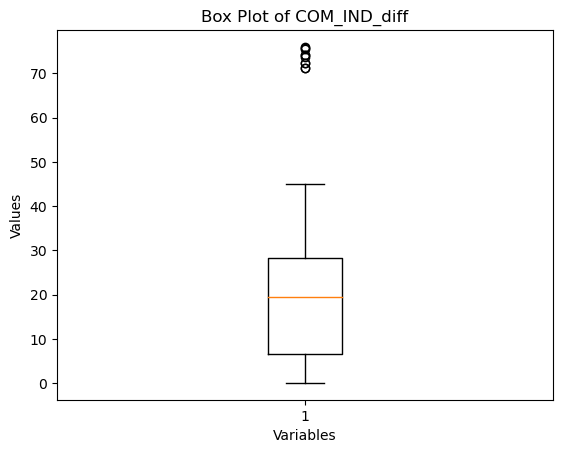

In [299]:

boxplot = plt.boxplot(abs(hyp_df5[['COM_IND_diff']]))

# Set title and labels
plt.title('Box Plot of COM_IND_diff')
plt.xlabel('Variables')
plt.ylabel('Values')

# Show the plot
plt.show()

In [ ]:
#at this point, we have concluded the median will be our minimum difference in classifying values as either commercial or industrial

In [302]:
median_diff = round(abs(hyp_df5['COM_IND_diff']).median(),2)
median_diff

19.48

In [368]:
hyp_df6 = hyp_df5

In [397]:
def what_category(row):
    if row['COM_IND_diff'] >= 8.08:
        return 'COM'
    elif row['COM_IND_diff'] <= -8.08:
        return 'IND'
    else:
        return 'NEITHER'


hyp_df6['GROUP'] = hyp_df6.apply(what_category,axis=1)
hyp_df7 = hyp_df6[hyp_df6['GROUP'] != 'NEITHER'].drop(columns=['RES.SALES','TOTAL.SALES'])

In [398]:
hyp_df7

4,OUTAGE.DURATION,COM.SALES,IND.SALES,COM_IND_diff,GROUP
32,95.0,36.98,27.34,9.64,COM
61,1219.0,29.75,40.75,-11.00,IND
70,1000.0,27.13,40.44,-13.31,IND
71,17339.0,26.67,43.03,-16.36,IND
72,9576.0,28.48,37.83,-9.35,IND
...,...,...,...,...,...
1522,95.0,22.66,52.51,-29.85,IND
1524,1548.0,21.73,54.12,-32.39,IND
1525,870.0,24.42,47.03,-22.61,IND
1531,59.0,40.12,23.31,16.81,COM


In [399]:
ind_df_diff = hyp_df7[hyp_df7['GROUP'] == 'IND']['OUTAGE.DURATION'].values
com_df_diff = hyp_df7[hyp_df7['GROUP'] == 'COM']["OUTAGE.DURATION"].values

In [400]:
obs_mean_com = hyp_df7.groupby('GROUP').mean()['OUTAGE.DURATION'].iloc[0]
obs_mean_ind = hyp_df7.groupby('GROUP').mean()['OUTAGE.DURATION'].iloc[1]
obs_mean_diff = obs_mean_com - obs_mean_ind
obs_mean_diff

-478.36106529347853

In [401]:
len(ind_df_diff)

106

In [404]:
n_permutations = 10000

shuffled_mean_diffs = np.zeros(n_permutations)

all_diff = np.concatenate((com_df_diff, ind_df_diff))

for i in range(n_permutations):
    np.random.shuffle(all_diff)
    
    shuffled_com_diff = all_diff[:len(com_df_diff)]
    shuffled_ind_diff = all_diff[len(com_df_diff):]
    
    shuffled_mean_diff = np.mean(shuffled_com_diff) - np.mean(shuffled_ind_diff)
    shuffled_mean_diffs[i] = shuffled_mean_diff
    
p_value = np.mean(shuffled_mean_diffs >= obs_mean_diff)



print("Observed Mean Difference:", obs_mean_diff)
print("p-value:", p_value)

Observed Mean Difference: -478.36106529347853
p-value: 0.7677


In [403]:
perm_diffs = np.zero(n_permutations)

AttributeError: module 'numpy' has no attribute 'zero'

## Step 3: Assessment of Missingness

In [375]:
# TODO

## Step 4: Hypothesis Testing

In [283]:
# TODO

## Step 5: Framing a Prediction Problem

In [ ]:
# TODO

## Step 6: Baseline Model

In [ ]:
# TODO

## Step 7: Final Model

In [ ]:
# TODO

## Step 8: Fairness Analysis

In [ ]:
# TODO